# Tensor

The tensor protocol lets you query the tensor (vector, matrix, etc.) representation of a bloq. For example, we can easily inspect the familiar unitary matrix representing the controlled-not operation:

In [1]:
from qualtran.bloqs.basic_gates import CNOT

cnot = CNOT()
cnot.tensor_contract().real

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

Bloqs can represent states, effects, and non-unitary operations. Below, we see the vector representation of the plus state and zero effect.

In [2]:
from qualtran.bloqs.basic_gates import PlusState, ZeroEffect

print('|+> \t', PlusState().tensor_contract())  # state
print('<0| \t', ZeroEffect().tensor_contract()) # effect

|+> 	 [0.70710678+0.j 0.70710678+0.j]
<0| 	 [1.+0.j 0.+0.j]


We can also look at the non-unitary `And` operation which outputs its result to a new qubit. As such, it's shape is $(2^3, 2^2)$ instead of being a square matrix.

In [3]:
from qualtran.bloqs.mcmt import And

And().tensor_contract().shape

(8, 4)

## Interface

The main way of accessing the dense, contracted, tensor representation of a bloq or composite bloq is through the `Bloq.tensor_contract()` method as we've seen.

All functionality for the tensor protocol is contained in the `qualtran.simulation.tensor` module. For example: `Bloq.tensor_contract()` is an alias for `bloq_to_dense(bloq: Bloq)` within that module. 

In [4]:
import numpy as np
from qualtran.simulation.tensor import bloq_to_dense

np.array_equal(
    cnot.tensor_contract(),
    bloq_to_dense(cnot)
)

True

## Additional functionality

### Direct manipulation of the `qtn.TensorNetwork`

A composite bloq can be easily transformed into a tensor network. We use [Quimb](https://quimb.readthedocs.io/) to handle efficient contraction of such networks.

The most important library function is `qualtran.simulation.tensor.cbloq_to_quimb`. This will build a quimb `qtn.TensorNetwork` tensor network representation of the composite bloq. You may want to manipulate this object directly using the full Quimb API. Otherwise, this function is used as the workhorse behind the public functions and methods like `Bloq.tensor_contract()`. 

As an example below, we decompose `MultiAnd` into a [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) consisting of a ladder of two-bit `And`s.

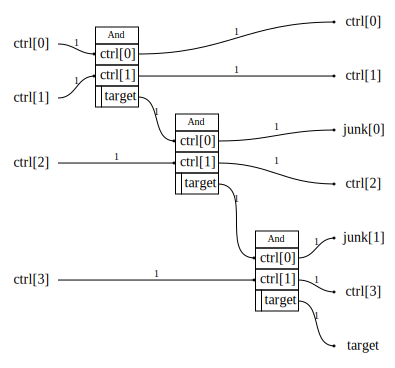

In [5]:
from qualtran.bloqs.mcmt import MultiAnd
from qualtran.drawing import show_bloq

bloq = MultiAnd(cvs=(1,)*4)
cbloq = bloq.decompose_bloq()
show_bloq(cbloq)

This composite bloq graph can be transformed into a quimb tensor network. Some of the visual flair has been lost, but the topology of the graph is the same.

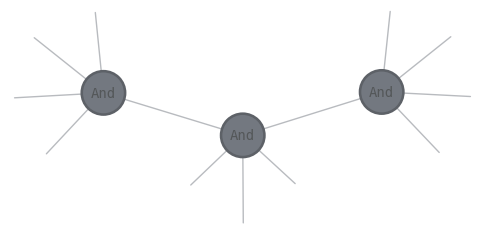

In [6]:
from qualtran.simulation.tensor import cbloq_to_quimb

tn = cbloq_to_quimb(cbloq)
tn.draw(show_inds=False)

With this `qtn.TensorNetwork` in hand, the entire suite of Quimb tools are available.

In [7]:
tn.contraction_info()

  Complete contraction:  abcde,efghi,ijklm->abcdfghjklm
         Naive scaling:  13
     Optimized scaling:  12
      Naive FLOP count:  2.458e+4
  Optimized FLOP count:  9.216e+3
   Theoretical speedup:  2.667e+0
  Largest intermediate:  2.048e+3 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   9           GEMM  efghi,abcde->fghiabcd           ijklm,fghiabcd->abcdfghjklm
  12           TDOT fghiabcd,ijklm->abcdfghjklm         abcdfghjklm->abcdfghjklm

### Quimb index format

In [`CompositeBloq`](/reference/qualtran/CompositeBloq.md), we form the compute graph by storing a list of nodes and edges. Quimb uses a different strategy for representing the tensor network graphs. To form a tensor network in Quimb, we provide a list of `qtn.Tensor` which contain not only the tensor data but also a list of "indices" that can form connections to other tensors. Similar to the Einstein summation convention, if two tensors each have an index with the same name: an edge is created in the tensor network graph and this shared index is summed over. These indices are traditionally short strings like `"k"`, but can be any hashable Python object. In [`CompositeBloq`](/reference/qualtran/CompositeBloq.md), the unique object that identifies a connection between bloqs is `qualtran.Connection`, so we use these connection objects as our indices.

Qualtran and Quimb both support "wires" with arbitrary bitsize. Qualtran uses bookkeeping bloqs like `Join` and `Split` to fuse and un-fuse indices. In theory, these operations should be free in the tensor contraction, as they are essentially an identity tensor. In our understanding, Quimb does not have special support for supporting these re-shaping operations within the tensor network graph. In versions of Qualtran prior to v0.5, split and join operations were tensored up to `n`-sized identity tensors. This would form a bottleneck in any contraction ordering. Therefore, we keep all the indices un-fused in the tensor network representation and use tuples of `(cxn, i)` for our tensor indices, where the second integer `i` indexes the individual bits in a register with `reg.dtype.num_qubits` > 1.

**In summary:**
 - Each tensor index is a tuple `(cxn, i)`
 - The `cxn: qualtran.Connection` entry identifies the connection between soquets in a Qualtran compute graph.
 - The second integer `i` is the bit index within high-bitsize registers, which is necessary due to technical restrictions.

In [8]:
# Use `get_right_and_left_inds` to get the quimb indices ordered according to
# the bloq's signature.

from qualtran.simulation.tensor import get_right_and_left_inds
left, right = get_right_and_left_inds(tn, bloq.signature)

print("Left outer inds:")
for cxn, i in left:
    print(' ', cxn.left)

print("Right outer inds")
for cxn, i in right:
    print(' ', cxn.right)

Left outer inds:
  And<0>.ctrl[0]
  And<0>.ctrl[1]
  And<1>.ctrl[1]
  And<2>.ctrl[1]
  And<1>.ctrl[0]
  And<2>.ctrl[0]
  And<2>.target
Right outer inds
  And<0>.ctrl[0]
  And<0>.ctrl[1]
  And<1>.ctrl[1]
  And<2>.ctrl[1]


### Flattening

A call to `Bloq.tensor_contract` will first "flatten" the bloq by doing `bloq.as_composite_bloq().flatten()`. This is a sensible default default for constructing tensor networks, as the best contraction performance can generally be achieved by keeping tensors as small as possible in the network. 

In Qualtran, we usually avoid flattening bloqs and strongly to prefer to work with one level of decomposition at a time. This is to avoid performance issues with large, abstract algorithms. But typically if the full circuit is large enough to cause performance issues with flattening it is also too large to simulate numerically; so an exception to the general advice is made here.

All bloqs in the flattened circuit must provide their explicit tensors. If your bloq's tensors ought to be derived from its decomposition: this is achieved by the previously mentioned flattening operation. If a bloq provides tensors through overriding `Bloq.my_tensors` _and also_ defines a decomposition, the explicit tensors will not be used (by default). This is because any bloq with a decomposition will be flattened. If you would like to control the flattening operation, use the free functions to control the tensor network construction and contraction.

In [9]:
# Stop flattening if e.g. a bloq supports explicit tensors _and_ a decomposition.
# Use the flatten predicate to control.
custom_flat = bloq.as_composite_bloq().flatten(lambda binst: binst.i != 2)
tn = cbloq_to_quimb(custom_flat)
len(tn.tensors)

41

## Implementation

The `qualtran.simulation.tensor` functions rely on the `Bloq.my_tensors(...)` method to implement the protocol. This is where a bloq's tensor information is actually encoded.

Usually, the most efficient way of supporting tensor simulation is by providing a decomposition for your bloq. However, bloq authors may want to override `my_tensors` if the bloq can't or shouldn't define a decomposition. The method takes dictionaries of incoming and outgoing indices (keyed by register name) to asist the author in matching up dimensions of their `np.ndarray` to the incoming and outgoing wires when constructing `qtn.Tensor`s.

The docstring for `Bloq.my_tensors` provides a complete, technical description of how to successfully override this method. In brief, the method must return one or more `qtn.Tensor`s that get added to the tensor network. The indices used to construct these **must** be of the correct form. Each tensor index is a tuple `(cxn, j)`. The connection entry comes from the `incoming` and `outgoing` arguments to the method. The `j` integer is the bit index within multi-bit registers.

New, we write our own `CNOT` bloq with custom tensors.

In [10]:
from functools import cached_property
from typing import Any, Dict, Tuple, List

import numpy as np
import quimb.tensor as qtn
from attrs import frozen

from qualtran import Bloq, Signature, Soquet, SoquetT, Register, Side

@frozen
class MyCNOT(Bloq):
    @cached_property
    def signature(self) -> 'Signature':
        return Signature.build(ctrl=1, target=1)

    def my_tensors(
        self, incoming: Dict[str, 'ConnectionT'], outgoing: Dict[str, 'ConnectionT']
    ) -> List['qtn.Tensor']:
        # The familiar CNOT matrix. We make sure to
        # cast this to np.complex128 so we don't accidentally
        # lose precision anywhere else in the contraction.
        matrix = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 1, 0],
        ], dtype=np.complex128)
        
        # According to our signature, we have two thru-registers.
        # This means two incoming and two outgoing wires.
        # We'll reshape our matrix into the more natural n-dimensional
        # tensor form.
        tensor = matrix.reshape((2,2,2,2))
        

        # This is a simple case: we only need one tensor and
        # each register is one bit.
        outgoing_inds = [
            (outgoing['ctrl'], 0),
            (outgoing['target'], 0),
        ]
        incoming_inds = [
            (incoming['ctrl'], 0),
            (incoming['target'], 0),
        ]
        
        return [qtn.Tensor(
            data=tensor, 
            inds=outgoing_inds + incoming_inds
        )]

In [11]:
# Sanity check
MyCNOT().tensor_contract()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

## Default Fallback

By default, the flattening operation in a given tensor contraction should mean that only a finite number of small, target-gateset bloqs
should need to explicitly override `my_tensors()`. 

If a bloq does not override `my_tensors(...)` and doesn't provide a decomposition, the tensor protocol will throw an error when trying to construct a tensor network.
 
For example, we author a `BellState` bloq. We define a decomposition but do not explicitly provide tensor information.

In [12]:
from qualtran import QBit
from qualtran.bloqs.basic_gates import PlusState, ZeroState

@frozen
class BellState(Bloq):
    @cached_property
    def signature(self) -> 'Signature':
        return Signature([
            Register('q0', QBit(), side=Side.RIGHT),
            Register('q1', QBit(), side=Side.RIGHT)
        ])

    def build_composite_bloq(self, bb):
        q0 = bb.add(PlusState())
        q1 = bb.add(ZeroState())

        q0, q1 = bb.add(CNOT(), ctrl=q0, target=q1)
        return {'q0': q0, 'q1': q1}


The system can still contract the tensor network implied by this bloq because it will automatically flatten the bloq.

In [13]:
print(BellState().tensor_contract())

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


If you don't flatten first, an error will be raised

In [14]:
try:
    cbloq_to_quimb(BellState().as_composite_bloq())
except NotImplementedError as e:
    print("Expected error because we didn't flatten first:", repr(e))

Expected error because we didn't flatten first: NotImplementedError('BellState does not support tensor simulation.')


## Properties and Relations

### Gates with factorized tensors

The `my_tensors` method can return multiple `Tensor` objects if there is a known factorization of the bloq's tensors. For example: CNOT can be written as a dense 4x4 matrix or by contracting the so-called COPY and XOR tensors. 

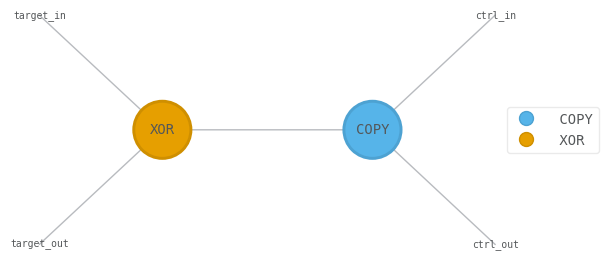

oset(['COPY'])
[[[1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j]]]

oset(['XOR'])
[[[1.+0.j 0.+0.j]
  [0.+0.j 1.+0.j]]

 [[0.+0.j 1.+0.j]
  [1.+0.j 0.+0.j]]]



In [15]:
from qualtran.bloqs.basic_gates import CNOT
from qualtran.simulation.tensor import (
    cbloq_to_quimb, get_right_and_left_inds
)

cbloq = CNOT().as_composite_bloq()
tn = cbloq_to_quimb(cbloq)

# Rename the indices to something less verbose
lefts, rights = get_right_and_left_inds(tn, cbloq.signature)
rename = {left: f'{left[0].left.reg.name}_in' for left in lefts}
rename |= {right: f'{right[0].right.reg.name}_out' for right in rights}
tn = tn.reindex(rename)

tn.draw(color=['COPY', 'XOR'], show_tags=True, initial_layout='spectral')
for tensor in tn:
    print(tensor.tags)
    print(tensor.data)
    print()